In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import zipfile

In [3]:
from six.moves import urllib
from six.moves import xrange

In [4]:
import numpy as np
import tensorflow as tf

c:\users\abhis\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
print(np.__version__)
print(tf.__version__)

1.14.1
1.6.0


In [6]:
DOWNLOADED_FILENAME = 'SampleText1.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path:', url_path)
        print('Download file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify file from: ' + url_path + '. Can you get it to the browser?')

In [7]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    return words

In [8]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016
maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path: http://mattmahoney.net/dc/text8.zip
Download file:  SampleText1.zip


In [9]:
vocabulary = read_words()
len(vocabulary)

17005207

In [10]:
vocabulary[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [11]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
    
    dictionary = dict()
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unknown_count += 1
        word_indexes.append(index)
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return word_counts, word_indexes, dictionary, reversed_dictionary    

In [12]:
VOCABULARY_SIZE = 5000
word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(
vocabulary, VOCABULARY_SIZE)

In [13]:
word_counts[:10]

[['UNKNOWN', 2735459],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [14]:
word_indexes[:10]

[0, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [15]:
import random
for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

free : 247
publication : 2054
engineering : 1072
mixed : 1959
vary : 2313
corporate : 2776
means : 363
almost : 417
adult : 2390
semitic : 4142


In [16]:
for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

2447 : joint
3083 : inducted
4629 : deeply
2342 : vietnam
3003 : descent
1115 : ways
468 : william
2409 : younger
3848 : railroad
161 : based


In [17]:
del vocabulary

In [18]:
global_index = 0

In [19]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1    #[skip_window input_word skip_window]
    
    buffer = collections.deque(maxlen = span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)

    for i in range(batch_size // num_skips):
        target = skip_window   #input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  #this is the input word
            labels[i * num_skips + j, 0] = buffer[target] #these are the context words
            
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    return batch, labels
        

In [20]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [21]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [22]:
labels

array([[195],
       [ 59],
       [128],
       [742],
       [ 59],
       [742],
       [ 46],
       [  6],
       [  2],
       [128]])

In [25]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ":", reversed_dictionary[labels[i][0]])

of : term
of : used
abuse : early
abuse : working
first : used
first : working
used : first
used : a
against : of


In [26]:
#Reset the global index because we updated while testing the batch code 
global_index = 0 


In [27]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace = False)


In [28]:
num_samples = 64

In [29]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

In [30]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [31]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)


In [32]:
embeddings = tf.Variable(
tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [33]:
embeddings

<tf.Variable 'Variable:0' shape=(5000, 50) dtype=float32_ref>

In [34]:
embed

<tf.Tensor 'embedding_lookup:0' shape=(128, 50) dtype=float32>

In [35]:
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev = 1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [60]:
loss = tf.reduce_mean(
tf.nn.nce_loss(weights = nce_weights, biases = nce_biases,
              labels = train_labels,
              inputs = embed,
              num_sampled = num_samples,
              num_classes = VOCABULARY_SIZE))

In [77]:
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [78]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
normalized_embeddings = embeddings / l2_norm


In [79]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
valid_embeddings

<tf.Tensor 'embedding_lookup_3:0' shape=(16, 50) dtype=float32>

In [80]:
normalized_embeddings

<tf.Tensor 'truediv_2:0' shape=(5000, 50) dtype=float32>

In [81]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b = True)


In [82]:
init = tf.global_variables_initializer()

In [83]:
num_steps = 20001

In [84]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
        word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = session.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                
            print('Average loss at step', step, ':', average_loss)
            average_loss = 0
            
        if step % 1000 == 0:
            sim = similarity.eval()
            
            for i in range(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 #nearest neighbours
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                
                for k in range(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0 : 199.57391357421875
Nearest to of: arrangement, built, survey, pictures, philosophy, mountains, total, democrats,
Nearest to these: fluid, victory, reconstruction, measurements, don, ball, movement, defining,
Nearest to known: meanwhile, paved, domain, taiwan, toward, clearly, matter, minimal,
Nearest to people: root, orthodox, remained, fate, therefore, vietnam, server, metropolitan,
Nearest to are: what, statute, experiment, global, kinds, enjoy, missouri, wife,
Nearest to would: unified, olympics, speak, language, complexity, dominated, reverse, principle,
Nearest to also: indonesia, lower, stress, analog, revolt, test, directed, mccarthy,
Nearest to if: binary, encouraged, suffered, cult, cultures, great, milk, males,
Nearest to after: ann, later, drop, physician, enforcement, release, seriously, historian,
Nearest to one: leadership, atom, director, grey, iv, making, lack, correspondence,
Nearest to they: intervention, passage, starting, ss, over, free, oxy

Nearest to of: and, in, tower, license, for, with, since, at,
Nearest to these: highly, communion, iowa, which, proposed, shaped, reconstruction, variants,
Nearest to known: domain, legends, ca, used, referred, codes, treated, shock,
Nearest to people: maintains, and, remained, emperor, released, tale, graduate, relatively,
Nearest to are: is, physician, males, bull, components, annual, dangerous, individual,
Nearest to would: should, to, them, compare, could, described, can, must,
Nearest to also: UNKNOWN, which, that, similar, ad, but, administrative, brain,
Nearest to if: recovered, regarded, binary, cult, males, described, where, beat,
Nearest to after: and, medical, among, buffalo, of, in, poet, trivia,
Nearest to one: seven, four, nine, three, six, eight, two, zero,
Nearest to they: ban, beijing, there, district, ruth, reference, true, variants,
Nearest to no: refused, bone, eternal, accounts, therapy, composers, but, disambiguation,
Nearest to at: serving, balance, luxembourg, o

Average loss at step 14000 : 6.210953724741936
Nearest to of: and, in, concentration, developing, genus, with, ocean, pierre,
Nearest to these: various, pi, programs, gate, keyboard, other, some, conventional,
Nearest to known: regarded, referred, described, treated, such, far, unknown, called,
Nearest to people: specification, french, organizations, female, majority, occur, meat, already,
Nearest to are: watch, were, other, is, diplomatic, vacuum, approaches, entrance,
Nearest to would: could, should, must, will, may, alone, can, stood,
Nearest to also: here, element, this, because, that, being, backed, usually,
Nearest to if: fully, called, what, vacuum, possible, except, when, correspondence,
Nearest to after: when, franco, poet, les, appearances, ion, before, won,
Nearest to one: nine, five, eight, two, six, zero, three, four,
Nearest to they: not, fully, bought, if, beijing, but, allowed, able,
Nearest to no: containing, studios, degrees, a, studio, generally, today, millions,
Nea

In [85]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    words = [x[0] for x in word_counts]
    np.save ('words.npy', words)

save_words_embeddings(final_embeddings, word_counts)

In [86]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize=(18, 18)) #in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
    plt.savefig(filename)
    plt.show(filename)

In [71]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500
#X_reduced = TruncatedSVD(n_components=2, random_state=0).fit_transform(NUM_PLOT_POINTS)
X_embedded = TSNE(n_components=2, perplexity=30, verbose=2, init='pca', method='exact', n_iter=5000)
low_dim_embs = X_embedded.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])
labels = [reversed_dictionary[i] for i in range(NUM_PLOT_POINTS)] 

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.266723
[t-SNE] Iteration 50: error = 74.7584462, gradient norm = 0.4737794 (50 iterations in 0.541s)
[t-SNE] Iteration 100: error = 74.2950067, gradient norm = 0.4687114 (50 iterations in 0.696s)
[t-SNE] Iteration 150: error = 77.1465267, gradient norm = 0.4522617 (50 iterations in 0.814s)
[t-SNE] Iteration 200: error = 76.0921664, gradient norm = 0.4568518 (50 iterations in 0.551s)
[t-SNE] Iteration 250: error = 74.3302636, gradient norm = 0.4631487 (50 iterations in 0.528s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.330264
[t-SNE] Iteration 300: error = 2.1854187, gradient norm = 0.0033461 (50 iterations in 0.535s)
[t-SNE] Iteration 350: error = 2.1225820, gradient norm = 0.0007976 (50 iterations in 0.529s)
[t-SNE] Iteration 400: error = 2.0931059, gradient norm = 0.0003670 (50 iterations in 0.543s)
[t-SNE] Iteration 450: error = 2.

In [87]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])
labels = [reversed_dictionary[i] for i in range(NUM_PLOT_POINTS)]

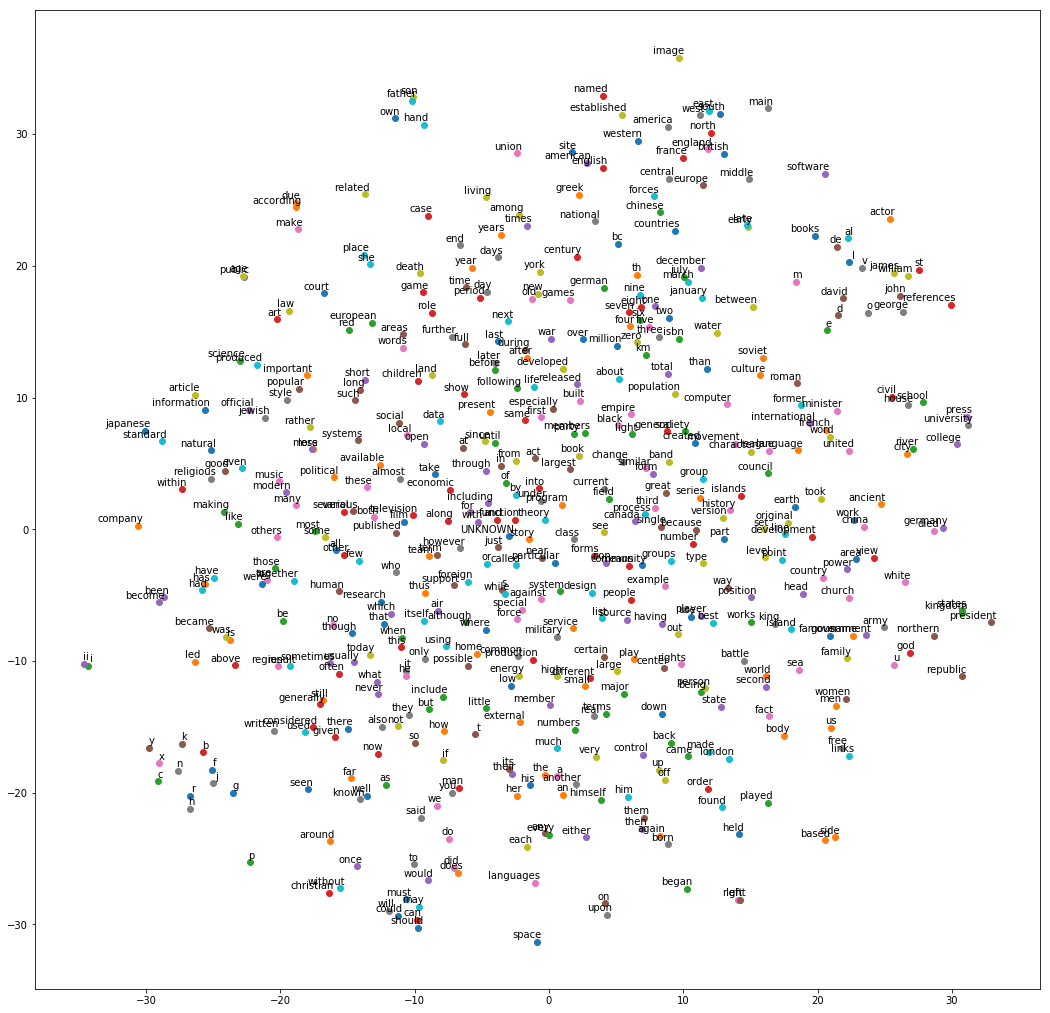

In [88]:
plot_with_labels(low_dim_embs, labels)